In [1]:
import os
import sys
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append("../")
from common import make_env, get_frame_skip_and_timestep
from evals import eval_TD_error_increasing_force

sys.path.append("../../")
import TD3

In [2]:
# Hyperparameters to consider
# response_times = [0.005, 0.01, 0.02]
response_times = [0.01, 0.02]
g_forces = [0, 5, 10, 15, 20]
seeds = [5, 6, 7, 8]

# Ensure all runs exist
for response_rate in response_times:
    for g_force in g_forces:
        for seed in seeds:
            if not os.path.isfile('../models/TD3_InvertedPendulum-v2_'+str(seed)+'_0.02_'+str(float(g_force))+'_'+str(response_rate)+'_1.0_True_256_final_actor'):
                print(f"Missing run: {response_rate, g_force, seed}")

In [3]:
df = pd.DataFrame(columns=["seed", "g_force", "response_rate", "eval_episode_num", "total_reward", "timestep", "time", "TD_error_1", "TD_error_2"])

# Environment hyperparameters
default_timestep = 0.02
default_frame_skip = 2
jit_duration = 0.02
env_name = "InvertedPendulum-v2"
delayed_env = True

# Experiment hyperparameters
EVAL_RESPONSE_RATE = 0.02
if EVAL_RESPONSE_RATE not in response_times: raise ValueError
NUM_EVAL_EPISODES = 2

for i, g_force in enumerate(g_forces):
    print(f"Status: {i+1}/{len(g_forces)}")
    for seed in seeds:

        # --- Load evaluation action-value function (critic) --- #

        # Get environment hyperparameters
        frame_skip, timestep, jit_frames = get_frame_skip_and_timestep(jit_duration, EVAL_RESPONSE_RATE)
        time_change_factor = (default_timestep * default_frame_skip) / (timestep * frame_skip)
        temp_env = make_env(env_name, seed, time_change_factor, timestep, frame_skip, delayed_env)
        temp_env.env.env._max_episode_steps = 100000
        state_dim = temp_env.observation_space[0].shape[0]
        action_dim = temp_env.action_space.shape[0]
        max_action = float(temp_env.action_space.high[0])
        
        # Initialise critic class
        kwargs = {
            "state_dim": state_dim,
            "action_dim": action_dim,
            "observation_space": temp_env.observation_space,
            "max_action": max_action,
            "discount": 0.99,
            "tau": 0.005,
            "delayed_env": delayed_env
        }
        kwargs["policy_noise"] = 2 * max_action
        kwargs["noise_clip"] = 0.5 * max_action
        kwargs["policy_freq"] = 2
        critic = TD3.TD3(**kwargs)

        # Load critic parameters
        arguments = ["TD3", env_name, seed, jit_duration, float(g_force), EVAL_RESPONSE_RATE, 1.0, delayed_env, 256, "best"]
        file_name = '_'.join([str(x) for x in arguments])
        if os.path.exists('../models/'+file_name+"_critic"):
            critic.load(f"../models/{file_name}")
        else:
            raise FileNotFoundError

        del temp_env

        # --- Evaluate agents of various response times --- #

        for response_rate in response_times:

            # Get environment hyperparameters
            frame_skip, timestep, jit_frames = get_frame_skip_and_timestep(jit_duration, response_rate)
            time_change_factor = (default_timestep * default_frame_skip) / (timestep * frame_skip)
            eval_env = make_env(env_name, seed, time_change_factor, timestep, frame_skip, delayed_env)
            eval_env.env.env._max_episode_steps = 100000
            state_dim = eval_env.observation_space[0].shape[0]
            action_dim = eval_env.action_space.shape[0]
            max_action = float(eval_env.action_space.high[0])
            
            # Initialise policy class
            kwargs = {
                "state_dim": state_dim,
                "action_dim": action_dim,
                "observation_space": eval_env.observation_space,
                "max_action": max_action,
                "discount": 0.99,
                "tau": 0.005,
                "delayed_env": delayed_env
            }
            kwargs["policy_noise"] = 2 * max_action
            kwargs["noise_clip"] = 0.5 * max_action
            kwargs["policy_freq"] = 2
            policy = TD3.TD3(**kwargs)

            # Load policy parameters
            arguments = ["TD3", env_name, seed, jit_duration, float(g_force), response_rate, 1.0, delayed_env, 256, "best"]
            file_name = '_'.join([str(x) for x in arguments])
            if os.path.exists('../models/'+file_name+"_critic"):
                policy.load(f"../models/{file_name}")
            else:
                raise FileNotFoundError

            # Evaluate policy and record TD error over episode
            evaluation_data = eval_TD_error_increasing_force(critic, policy, env_name, NUM_EVAL_EPISODES, time_change_factor, timestep, frame_skip, jit_frames, response_rate, delayed_env)

            for eval_episode_num, episode_data in evaluation_data.items():
                total_reward = episode_data[0]
                episode_TD_error_1 = episode_data[1]
                episode_TD_error_2 = episode_data[2]
                assert len(episode_TD_error_1) == len(episode_TD_error_2)
                for timestep in range(len(episode_TD_error_1)):
                    df.loc[len(df.index)] = [seed, g_force, response_rate, eval_episode_num, total_reward, (timestep + 1), (timestep + 1) * response_rate, episode_TD_error_1[timestep], episode_TD_error_2[timestep]]

Status: 1/5


/home/joshua/research/tami/adaptive-response/venv/lib/python3.7/site-packages/gym/core.py:173: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "


Status: 2/5
Status: 3/5
Status: 4/5
Status: 5/5


In [4]:
torch.save(df, "dataframe_TD_error")

In [5]:
df = torch.load("dataframe_TD_error")

### TD Error over Episode 

In [6]:
sns.set(rc={'figure.figsize':(14,10)})
sns.set_theme(style="whitegrid")

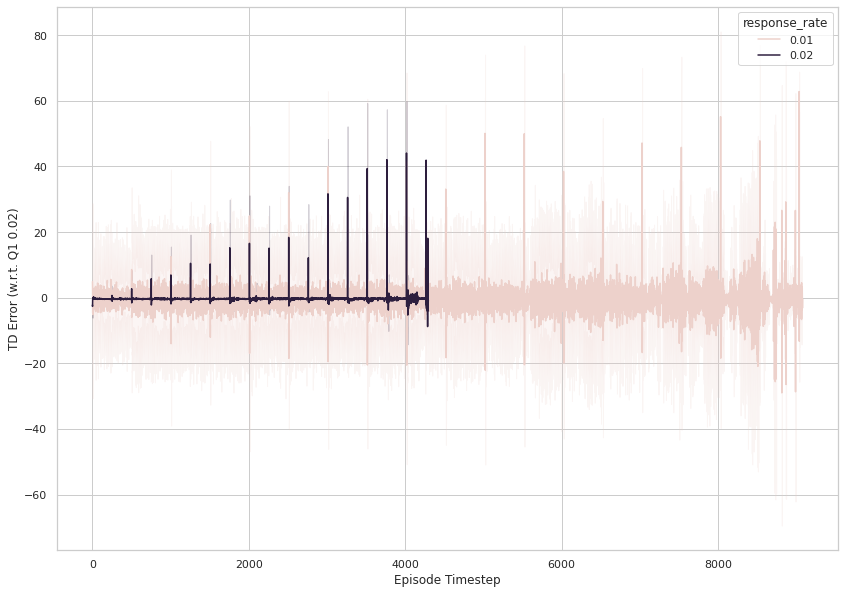

In [7]:
ax = sns.lineplot(data=df, x="timestep", y="TD_error_1", hue="response_rate", ci="sd")
ax.set(xlabel="Episode Timestep", ylabel="TD Error (w.r.t. Q1 0.02)")
plt.show()

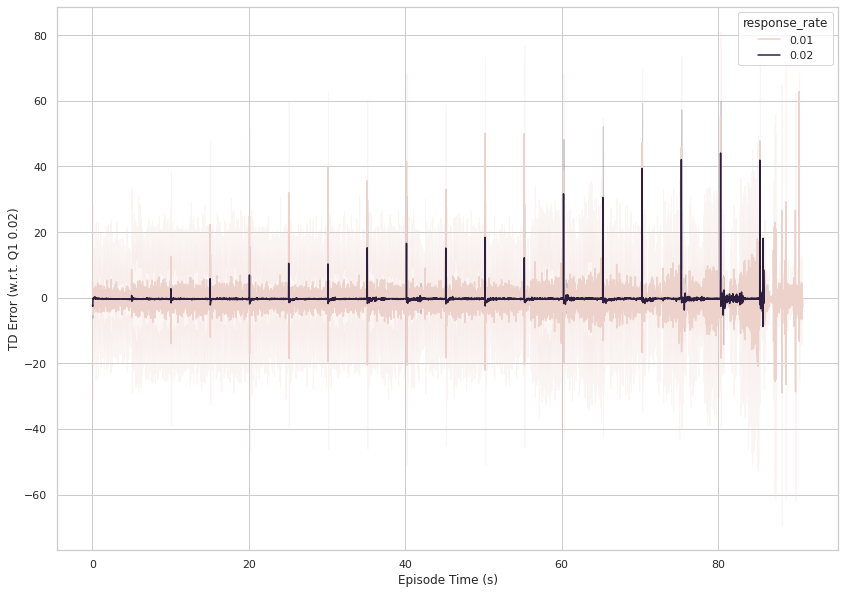

In [8]:
ax = sns.lineplot(data=df, x="time", y="TD_error_1", hue="response_rate", ci="sd")
ax.set(xlabel="Episode Time (s)", ylabel="TD Error (w.r.t. Q1 0.02)")
plt.show()

### TD Error for Response Rates

In [9]:
sns.set_theme(style="whitegrid")

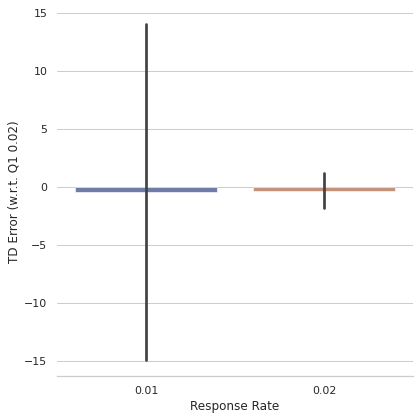

In [10]:
g = sns.catplot(data=df, kind="bar", x="response_rate", y="TD_error_1", ci="sd", palette="dark", alpha=0.6, height=6)
g.despine(left=True)
g.set_axis_labels("Response Rate", "TD Error (w.r.t. Q1 0.02)")
plt.show()

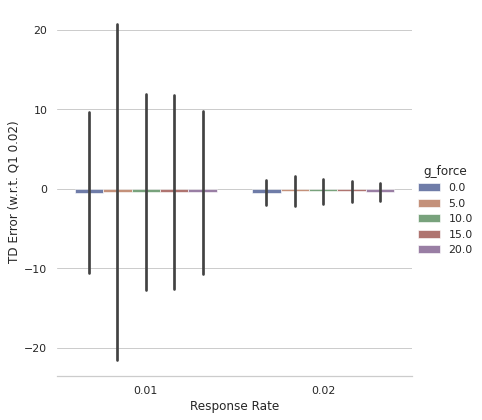

In [11]:
g = sns.catplot(data=df, kind="bar", x="response_rate", y="TD_error_1", hue="g_force", ci="sd", palette="dark", alpha=0.6, height=6)
g.despine(left=True)
g.set_axis_labels("Response Rate", "TD Error (w.r.t. Q1 0.02)")
plt.show()